In [10]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import yaml
import omegaconf
import hydra
from hydra import initialize, compose

from framework.unifying_framework import UnifyingFramework
from framework.diffusion.consistency_framework import CMFramework
from framework.diffusion.edm_framework import EDMFramework

from utils import common_utils
from utils.fid_utils import FIDUtils
from utils.fs_utils import FSUtils

from tqdm import tqdm

In [11]:
# default_path = "/home/djfelrl11/diffusion/configs/config_cm_score.yaml"
config_path = "configs"
# default_path = "config_cm_score"
config_denoiser = "config_denoiser"
config_consistency = "config_consistency"
# config_path = "/home/djfelrl11/diffusion/experiments/0906_verification_unet_block_1/config.yaml"
rng = jax.random.PRNGKey(42)

with initialize(version_base=None, config_path=config_path):
    denoiser_config = compose(config_name=config_denoiser)
    consistency_config = compose(config_name=config_consistency)
denoiser_config["do_training"] = False
consistency_config["do_training"] = False
model_type = denoiser_config.type


# Load the model
# rng, second_rng = jax.random.split(rng)
# diffusion_framework = UnifyingFramework(model_type, denoiser_config, second_rng)

rng, denoiser_rng = jax.random.split(rng, 2)
rng, consistency_rng = jax.random.split(rng, 2)
# denoiser_framework = diffusion_framework.framework
fid_utils = FIDUtils(consistency_config)
denoiser_fs_utils = FSUtils(denoiser_config)
conisstency_fs_utils = FSUtils(consistency_config)

denoiser_framework = EDMFramework(denoiser_config, denoiser_rng, denoiser_fs_utils, None)
consistency_framework = CMFramework(consistency_config, consistency_rng, conisstency_fs_utils, None)

In [3]:
sigma_max = 80
sigma_min = 0.02
rho = 7
n_timestep = denoiser_config.framework.diffusion.n_timestep
sweep_timestep = jnp.arange(n_timestep)

t_steps = (sigma_max ** (1 / rho) + sweep_timestep / (n_timestep - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho

In [4]:
num_sample = 8

datasets = common_utils.load_dataset_from_tfds(n_jitted_steps=1, x_flip=False, batch_size=num_sample)

import os
tmp_saving_dir = "tmp"
if not os.path.exists(tmp_saving_dir):
    os.makedirs(tmp_saving_dir)

sweep_timestep = range(denoiser_config.framework.diffusion.n_timestep)

# for timestep in sweep_timestep:
timestep = 17 # TMP
rng, sampling_rng = jax.random.split(rng)
data = next(datasets)
# data = data[0][:, 1, ...]
data = data[0][:, 0, ...]

noise = jax.random.normal(sampling_rng, shape=data.shape)
noise = noise * t_steps[timestep]

# sample = denoiser_framework.sampling(num_sample, original_data=data, sweep_timesteps=timestep)
# sample = denoiser_framework.sampling(num_sample, original_data=data)
sample = denoiser_framework.sampling_denoiser(num_sample, original_data=data, sweep_timesteps=timestep, noise=noise)
# sample = consistency_framework.sampling_cm_intermediate(num_sample, original_data=data, sweep_timesteps=timestep, noise=noise)

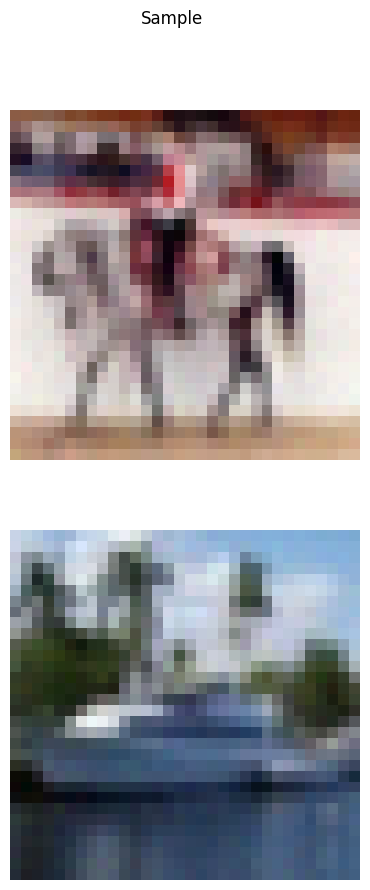

In [5]:
# num_sample_in_
def viz_sample(sample, title="Sample"):
    sample = sample.reshape((sample.shape[0], 32, 32, 3))
    sample = sample[:2]
    
    sample = (sample + 1) / 2
    sample = jnp.clip(sample, 0, 1)

    plt.figure(figsize=(10, 10))
    plt.suptitle(title)
    # for i in range(sample.shape[0]):
    #     plt.subplot(4, 4, i + 1)
    #     plt.imshow(sample[i])
    #     plt.axis("off")
    for i in range(sample.shape[0]):
        plt.subplot(2, 1, i + 1)
        plt.imshow(sample[i])
        plt.axis("off")
    plt.show()
viz_sample(sample)

Start 0 / 18


100%|██████████| 125/125 [00:38<00:00,  3.26it/s]


Error of mean:  [0.08895181 0.04757538 0.06949811 0.05478324 0.04515707 0.08821204
 0.0477668  0.05285668]
Total mean of error:  0.061850138


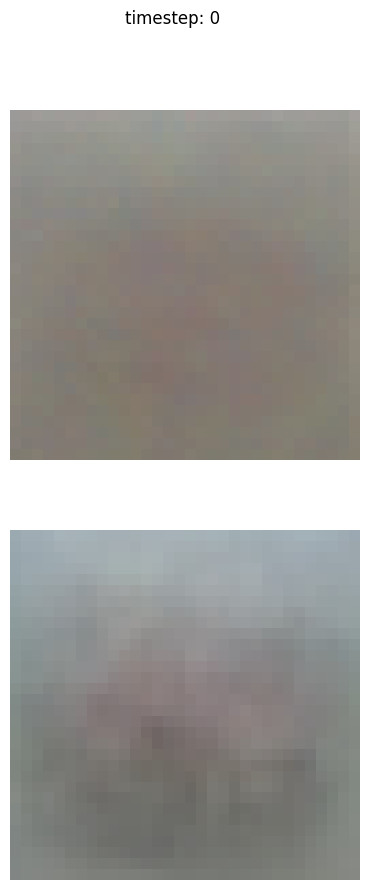

Start 1 / 18


100%|██████████| 125/125 [00:37<00:00,  3.32it/s]


Error of mean:  [0.06116615 0.05506507 0.06231226 0.09462705 0.09775689 0.07419872
 0.08436501 0.04366223]
Total mean of error:  0.07164417


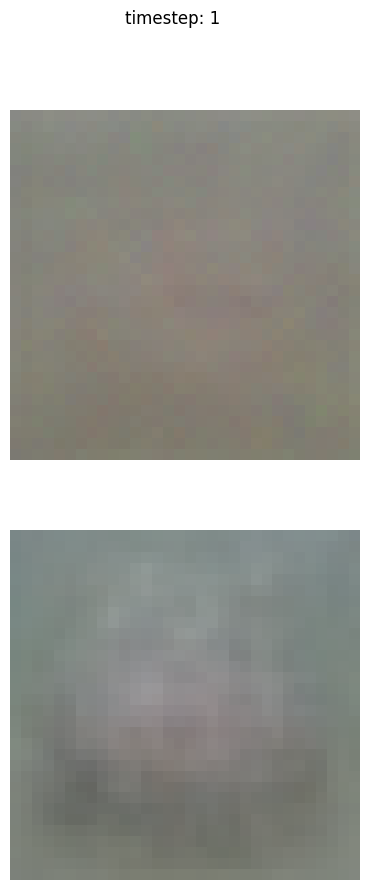

Start 2 / 18


100%|██████████| 125/125 [00:38<00:00,  3.28it/s]


Error of mean:  [0.24946272 0.21761161 0.06599117 0.09526527 0.06789302 0.07832623
 0.21047734 0.06301385]
Total mean of error:  0.13100515


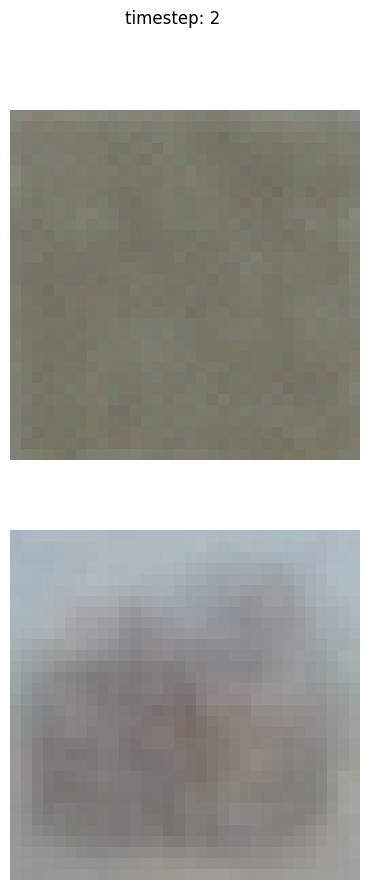

Start 3 / 18


100%|██████████| 125/125 [00:37<00:00,  3.30it/s]


Error of mean:  [0.0417695  0.0415998  0.05510992 0.11624406 0.04197118 0.07134186
 0.07552528 0.11820267]
Total mean of error:  0.07022053


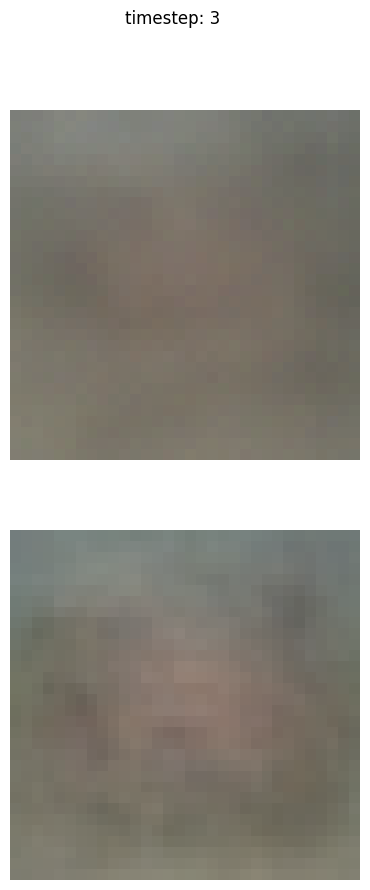

Start 4 / 18


100%|██████████| 125/125 [00:37<00:00,  3.32it/s]


Error of mean:  [0.08225816 0.05741783 0.10404894 0.11874662 0.1290223  0.07422222
 0.06324215 0.12958491]
Total mean of error:  0.09481789


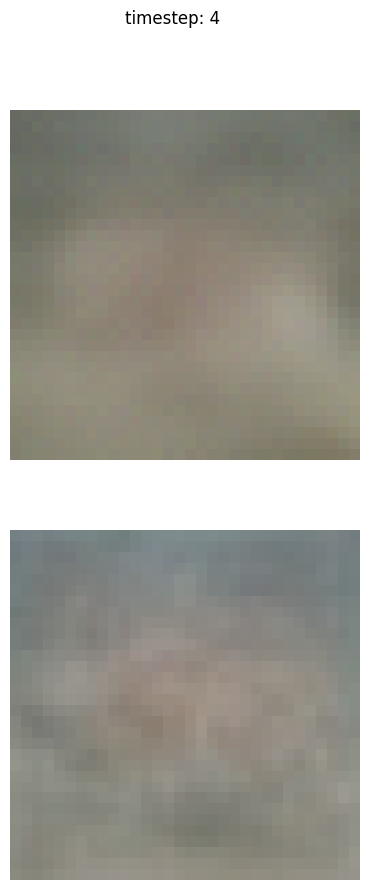

Start 5 / 18


100%|██████████| 125/125 [00:39<00:00,  3.20it/s]


Error of mean:  [0.06139958 0.10961922 0.10331565 0.09241818 0.10172721 0.12688734
 0.07308307 0.10076936]
Total mean of error:  0.096152455


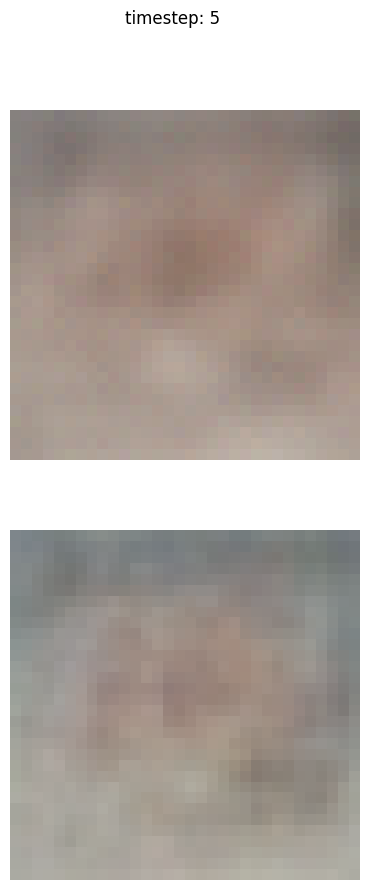

Start 6 / 18


100%|██████████| 125/125 [00:38<00:00,  3.27it/s]


Error of mean:  [0.07382321 0.10741013 0.09013    0.09636971 0.11987597 0.08005795
 0.10966957 0.10759921]
Total mean of error:  0.09811697


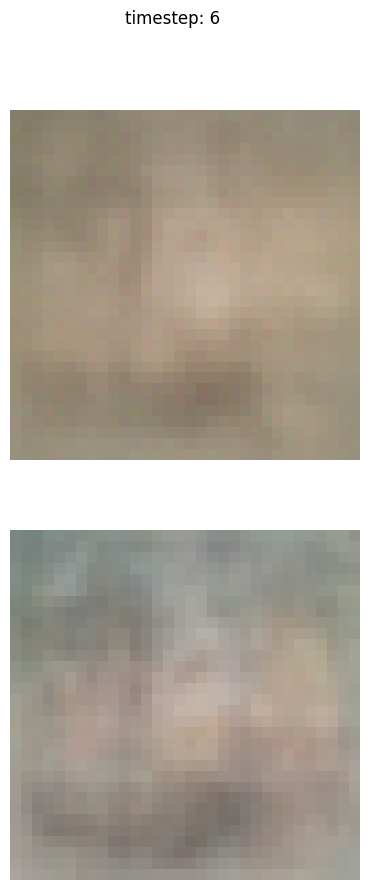

Start 7 / 18


100%|██████████| 125/125 [00:38<00:00,  3.26it/s]


Error of mean:  [0.10744663 0.13235374 0.1206007  0.09206509 0.12935987 0.14721146
 0.12184247 0.11797705]
Total mean of error:  0.12110713


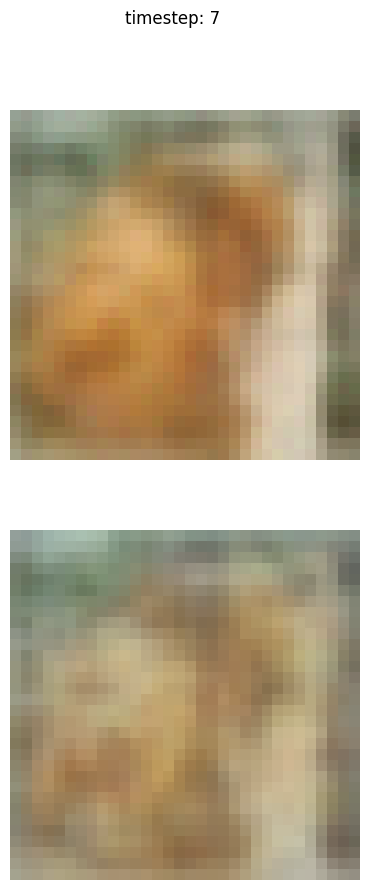

Start 8 / 18


100%|██████████| 125/125 [00:38<00:00,  3.26it/s]


Error of mean:  [0.20669119 0.16943489 0.19743995 0.14510523 0.19637316 0.15400219
 0.17370497 0.14752455]
Total mean of error:  0.17378452


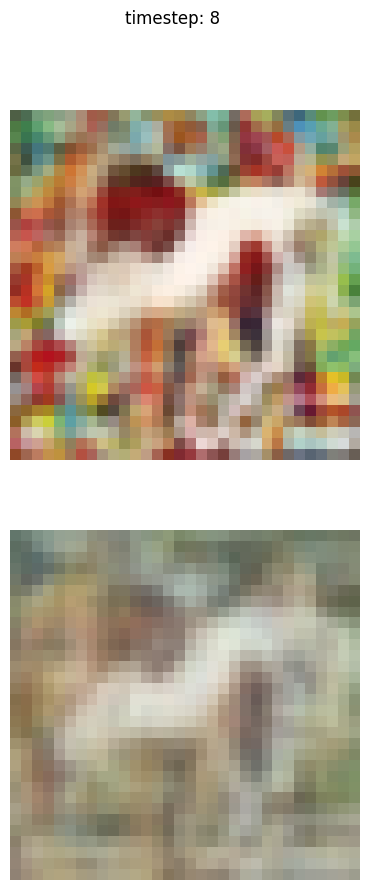

Start 9 / 18


100%|██████████| 125/125 [00:38<00:00,  3.27it/s]


Error of mean:  [0.20962471 0.21156143 0.2018042  0.22621462 0.23233628 0.23671493
 0.20933603 0.20599662]
Total mean of error:  0.2166986


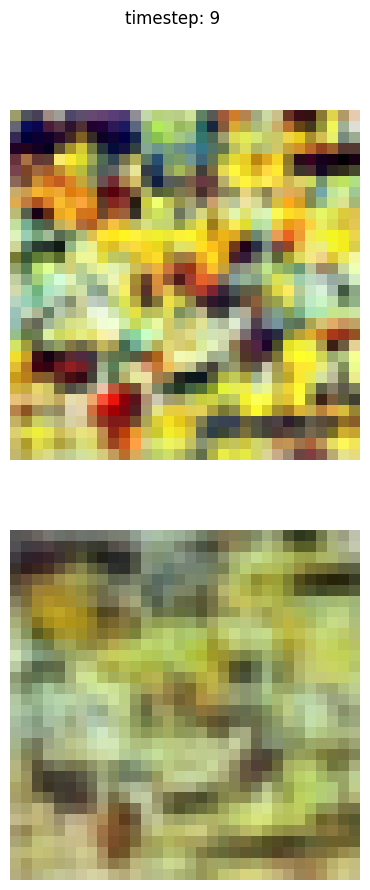

Start 10 / 18


100%|██████████| 125/125 [00:38<00:00,  3.25it/s]


Error of mean:  [0.19120261 0.18922013 0.18793933 0.19582169 0.19718388 0.17132565
 0.1791514  0.18800561]
Total mean of error:  0.18748128


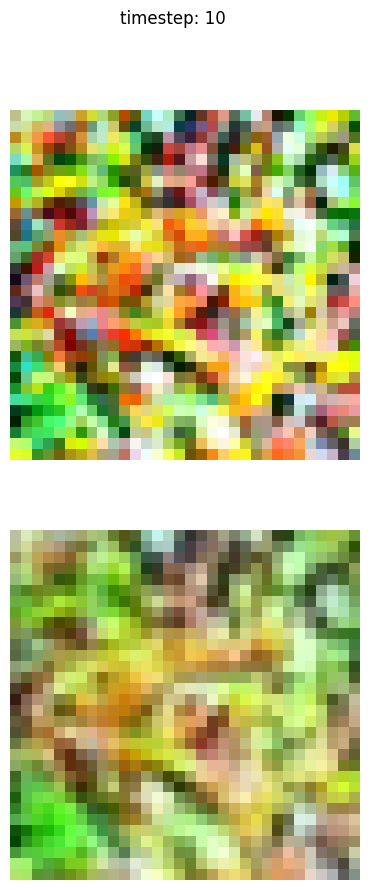

Start 11 / 18


100%|██████████| 125/125 [00:39<00:00,  3.19it/s]


Error of mean:  [0.13839802 0.14512734 0.14395052 0.14251168 0.13816375 0.1352838
 0.13668743 0.14098476]
Total mean of error:  0.1401384


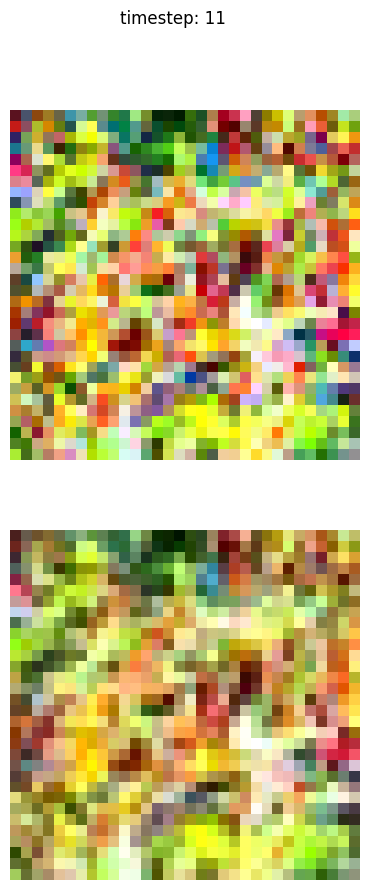

Start 12 / 18


100%|██████████| 125/125 [00:38<00:00,  3.24it/s]


Error of mean:  [0.08447532 0.09582368 0.08603432 0.08623048 0.08595437 0.08819833
 0.08854127 0.08644661]
Total mean of error:  0.08771305


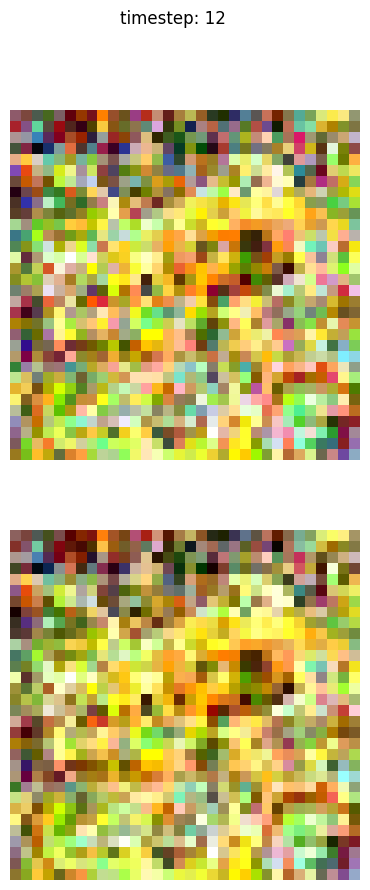

Start 13 / 18


100%|██████████| 125/125 [00:39<00:00,  3.18it/s]


Error of mean:  [0.05063945 0.05850661 0.05484103 0.05614777 0.05301313 0.05552065
 0.05136696 0.05395202]
Total mean of error:  0.054248452


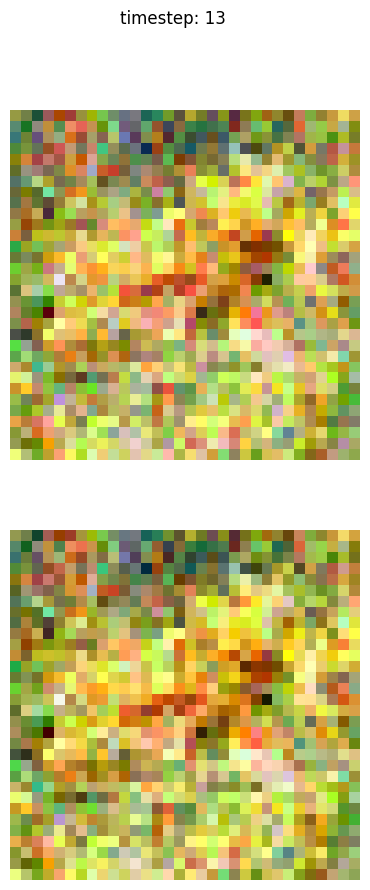

Start 14 / 18


100%|██████████| 125/125 [00:39<00:00,  3.19it/s]


Error of mean:  [0.02629523 0.03351435 0.03145578 0.02879254 0.02860077 0.0301554
 0.02631832 0.03126638]
Total mean of error:  0.029549846


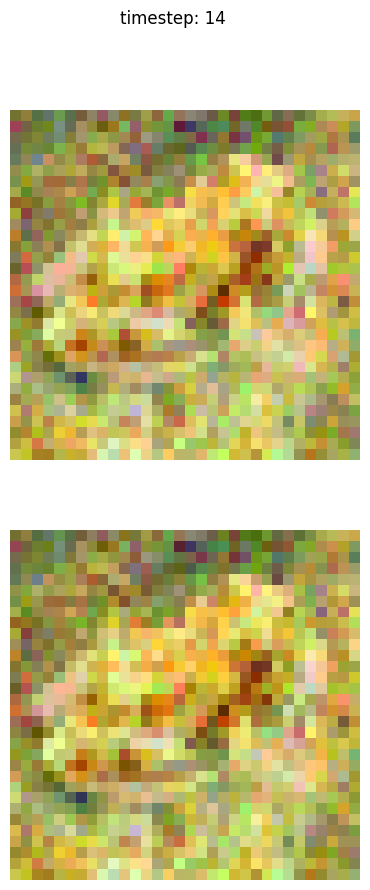

Start 15 / 18


100%|██████████| 125/125 [00:39<00:00,  3.19it/s]


Error of mean:  [0.01216798 0.0162976  0.01570666 0.01348515 0.01397933 0.01529308
 0.01095166 0.01559579]
Total mean of error:  0.014184656


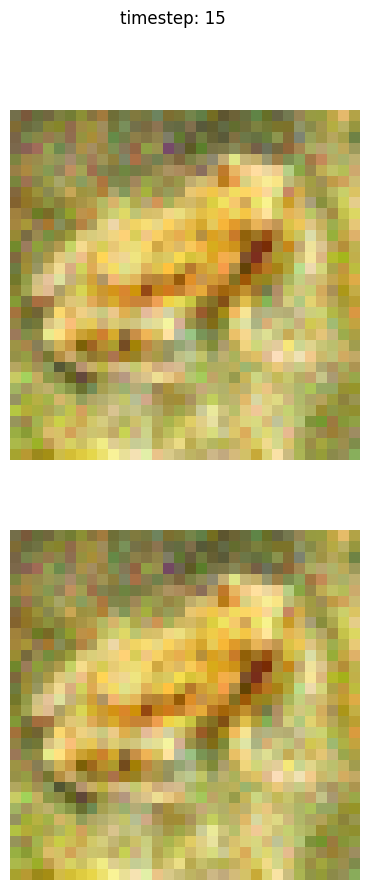

Start 16 / 18


100%|██████████| 125/125 [00:38<00:00,  3.25it/s]


Error of mean:  [0.00448503 0.0055276  0.00540965 0.00476796 0.00507955 0.00525274
 0.0041596  0.00529015]
Total mean of error:  0.004996535


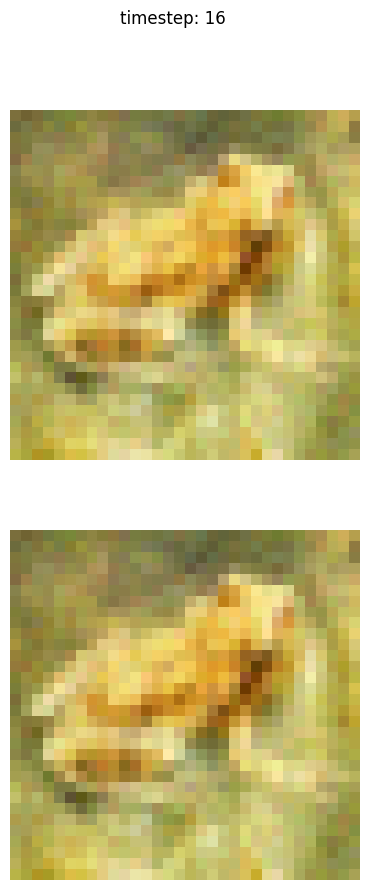

Start 17 / 18


100%|██████████| 125/125 [00:39<00:00,  3.17it/s]


Error of mean:  [0.00145528 0.00142386 0.00146414 0.00145158 0.00148142 0.00146631
 0.0014699  0.00146951]
Total mean of error:  0.0014602495


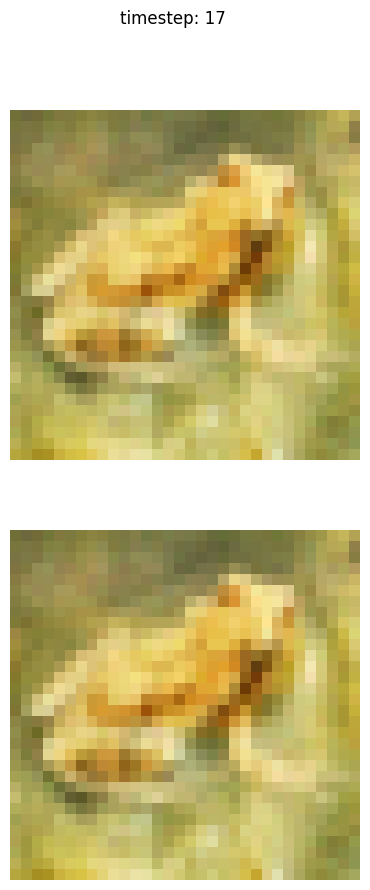

In [6]:
# The number of multiple datapoints
num_sample = 1000

data = next(datasets)
data = data[0][:, 0, ...] # 8 samples

# error_dict = {}
error_x_label = []
error_y_label = []

# tmp_timestep = 60
# for timestep in range(0, n_timestep, 6):
# for timestep in range(tmp_timestep, 1, -1):
for timestep in range(0, n_timestep):
# for timestep in range(n_timestep - 1, -1, -1):
    # if timestep == 18:
    #     timestep = 17
    # timestep = 9
    print(f"Start {timestep} / {n_timestep}")
    
    rng, sampling_rng = jax.random.split(rng)
    noise = jax.random.normal(sampling_rng, shape=data.shape) * t_steps[timestep]
    # noise = jax.random.normal(sampling_rng, shape=data.shape) * timestep

    # Get denoiser output
    denoiser_output = denoiser_framework.sampling_denoiser(num_sample, original_data=data, sweep_timesteps=timestep, noise=noise)

    # Get consistency output
    consistency_output = consistency_framework.sampling_cm_intermediate(num_sample, original_data=data, sweep_timesteps=timestep, noise=noise)

    # Sample multiple datapoints
    sampling_list = []
    num_batch = num_sample // consistency_output.shape[0]
    for i in tqdm(range(num_batch)):
        rng, sampling_rng = jax.random.split(rng)
        new_noise = jax.random.normal(sampling_rng, shape=consistency_output.shape) * t_steps[timestep]
        # new_noise = jax.random.normal(sampling_rng, shape=consistency_output.shape) * timestep

        second_consistency_output = consistency_framework.sampling_cm_intermediate(
            num_sample, original_data=consistency_output, sweep_timesteps=timestep, noise=new_noise)
        sampling_list.append(second_consistency_output)

    # sampling_list = jnp.concatenate(sampling_list, axis=0)
    sampling_list = jnp.stack(sampling_list, axis=0)
    second_consistency_output_empirical_mean = jnp.mean(sampling_list, axis=0)
    # denoiser_output_empirical_mean = jnp.mean(denoiser_output, axis=0)
    error = jnp.mean(jnp.abs(second_consistency_output_empirical_mean - denoiser_output), axis=(-1, -2, -3))
    # error = jnp.mean(jnp.abs(second_consistency_output_empirical_mean - data), axis=(-1, -2, -3))
    # error = jnp.mean(jnp.abs(second_consistency_output_empirical_mean - denoiser_output_empirical_mean))
    print("Error of mean: ", error.flatten())
    print("Total mean of error: ", jnp.mean(error))

    error_x_label.append(timestep)
    error_y_label.append(jnp.mean(error))

    viz_list = jnp.concatenate([denoiser_output[0], second_consistency_output_empirical_mean[0]], axis=0)
    viz_sample(viz_list, title=f"timestep: {timestep}")


In [7]:
total_error_mean = jnp.mean(jnp.array(error_y_label))
total_error_var = jnp.var(jnp.array(error_y_label))
print("Total error mean: ", total_error_mean)
print("Total error var: ", total_error_var)

Total error mean:  0.091953896
Total error var:  0.0036148445


Text(0.5, 0, 'Timestep')

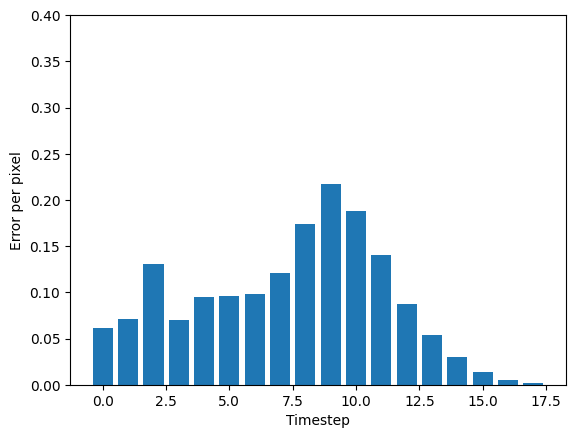

In [8]:
fig, ax = plt.subplots(1)

ax.bar(error_x_label, error_y_label)
y_max = 0.4
ax.set_ylim([0, y_max])
ax.set_ylabel("Error per pixel")
ax.set_xlabel("Timestep")



In [9]:
log_file_name = "compare_mean_log.txt"
with open(log_file_name, "a") as f:
    f.write(f"Exp name: {consistency_config['exp_name']}\n")
    f.write(f"Total error mean: {total_error_mean}\n")
    f.write(f"Total error var: {total_error_var}\n")
    f.write(f"Sigma max: {sigma_max}\n")
    f.write(f"Sigma min: {sigma_min}\n")
    f.write(f"Rho: {rho}\n")
    f.write(f"n_timestep: {n_timestep}\n")
    f.write(f"y_max: {y_max}\n")
    f.write("\n")
    f.write("\n")
    f.write("\n")

fig.savefig(f"{consistency_config['exp_name']}.png")

<Figure size 640x480 with 0 Axes>